# Проект: вариант 2
## Задание 1. A/B–тестирование
### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

* `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

* На какие метрики Вы смотрите в ходе анализа и почему?
* Имеются ли различия в показателях и с чем они могут быть связаны?
* Являются ли эти различия статистически значимыми?
* Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

* При выполнении тестового задания необходимо использовать язык программирования Python. 
* В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
* Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

## Задание 2. SQL
### 2.1 Очень усердные ученики.

### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

Дана таблица `default.peas`:

Название атрибута | Тип атрибута | Смысловое значение
------------------|--------------|-------------------
st_id | int | ID ученика
timest | timestamp | Время решения карточки
correct | bool | Правильно ли решена горошина?
subject | text | Дисциплина, в которой находится горошина

Необходимо написать <ins>оптимальный запрос</ins>, который даст информацию о количестве очень усердных студентов.

*NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.*

### 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: `default.peas` (см. выше), `default.studs`:

Название атрибута | Тип атрибута |Смысловое значение
------------------|--------------|-------------------
st_id|	int |	ID ученика
test_grp	|text 	|Метка ученика в данном эксперименте

и `default.final_project_check`:


Название атрибута	|Тип атрибута 	|Смысловое значение
------------------|--------------|-------------------
st_id|	int |	ID ученика
sale_time|	timestamp	|Время покупки
money|	int	|Цена, по которой приобрели данный курс
subject|	text |	Дисциплина, на которую приобрели полный доступ

Необходимо <ins>в одном запросе</ins> выгрузить следующую информацию о группах пользователей:

* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

**Активным** считается пользователь, за все время решивший **больше** 10 задач правильно в любых дисциплинах.

**Активным** по математике считается пользователь, за все время решивший **2 или больше задач** правильно по математике.

## Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

-------------------------------

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
import numpy as np
from scipy.stats import norm 
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import re

In [401]:
# получаем прямую ссылку на файлы
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'


# ссылки на данные с указанием разделителя csv-файла
links_dic = {
    'groups': ['https://disk.yandex.ru/d/58Us0DWOzuWAjg', ';'],
    'groups_add': ['https://disk.yandex.ru/d/3aARY-P9pfaksg', ','],
    'active_studs': ['https://disk.yandex.ru/d/prbgU-rZpiXVYg', ','],
    'checks': ['https://disk.yandex.ru/d/84hTmELphW2sqQ', ';']
            }

# скачиваем файлы
for csv_filename, csv_link in links_dic.items():
    final_url = base_url + urlencode(dict(public_key=csv_link[0]))
    response = requests.get(final_url)
    download_url = response.json()['href']
    globals()[csv_filename] = pd.read_csv(download_url, sep=csv_link[1])

Посмотрим на данные:

In [402]:
print(groups.head(), '\n')
print(groups.info(), '\n')
print('Уникальных ID в датасете:', groups.id.nunique())

     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None 

Уникальных ID в датасете: 74484


In [403]:
print(groups_add.head(), '\n')
print(groups_add.info(), '\n')
print('Уникальных ID в датасете:', groups_add.id.nunique())

        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None 

Уникальных ID в датасете: 92


In [404]:
print(active_studs.head(), '\n')
print(active_studs.info(), '\n')
print('Уникальных ID в датасете:', active_studs.student_id.nunique())

   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None 

Уникальных ID в датасете: 8341


In [405]:
print(checks.head(), '\n')
print(checks.info(), '\n')
print('Уникальных ID в датасете:', checks.student_id.nunique())

   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None 

Уникальных ID в датасете: 541


Проверим, учтены ли данные из `groups_add` в `active_studs` и `checks`:

In [406]:
print('Количество учтенных ID в active_studs:', groups_add.query('id in @active_studs.student_id').shape[0], 
      '\nКоличество учтенных ID в checks:', groups_add.query('id in @checks.student_id').shape[0])

Количество учтенных ID в active_studs: 13 
Количество учтенных ID в checks: 1


Соединим датасет `groups` c датасетом `groups_add`, т.к. второй является дополнением первого:

In [423]:
print('Количество строк было:', groups_add.id.count() + groups.id.count(), 
      '\nКоличество строк после соединения:', pd.concat([groups, groups_add]).id.count(),
      '\nСоединение прошло верно!' if groups_add.id.count() + groups.id.count()
                                                        == pd.concat([groups, groups_add]).id.count()
                                                     else '\nНеверное количество!')


Количество строк было: 74576 
Количество строк после соединения: 74576 
Соединение прошло верно!


In [385]:
print('Распределение всех пользователей по группам: \nГруппа A:', 
      groups_total.grp.value_counts()[1], '\nГруппа B:',
      groups_total.grp.value_counts()[0], '\nВсего:',
      groups_total.grp.value_counts()[1] +
      groups_total.grp.value_counts()[0])

Распределение всех пользователей по группам: 
Группа A: 14693 
Группа B: 59883 
Всего: 74576


In [384]:
paid_not_active = checks.query('student_id not in @active_studs.student_id')
print('Количество пользователей из списка активных, но не вошедших в общий список:', 
      active_studs.query('student_id not in @groups_total.id').shape[0],
     '\nКоличество оплативших пользователей, отсутствующих в общем списке:',
      checks.query('student_id not in @groups_total.id').shape[0],
     '\nКоличество оплативших пользователей, отсутствующих в списке активных в дни проведения теста:',
     paid_not_active.shape[0])

Количество пользователей из списка активных, но не вошедших в общий список: 0 
Количество оплативших пользователей, отсутствующих в общем списке: 0 
Количество оплативших пользователей, отсутствующих в списке активных в дни проведения теста: 149


-------------
Получается, что в период проведения экспериментов были оплаты и от тех студентов, которые не посещали платформу. Возможно, это автоматические оплаты.

In [386]:
print('Распредление checks по группам: \nГруппа A:', 
      groups_total.query('id in @checks.student_id').grp.value_counts()[0], '\nГруппа B:',
      groups_total.query('id in @checks.student_id').grp.value_counts()[1], '\nВсего:', 
      groups_total.query('id in @checks.student_id').grp.value_counts()[0] + 
      groups_total.query('id in @checks.student_id').grp.value_counts()[1])

Распредление checks по группам: 
Группа A: 434 
Группа B: 107 
Всего: 541


In [387]:
print('Оплатили, но не в списке активных, количество по группам:\nГруппа A:', 
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[0], '\nВсего:',
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[1] + 
      groups_total.query('id in @paid_not_active.student_id').grp.value_counts()[0])

Оплатили, но не в списке активных, количество по группам:
Группа A: 29 
Группа B: 120 
Всего: 149


In [388]:
print('Распределение active_studs по группам: \nГруппа A:', 
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[0], '\nВсего:',
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[1] + 
      groups_total.query('id in @active_studs.student_id').grp.value_counts()[0])

Распределение active_studs по группам: 
Группа A: 1538 
Группа B: 6803 
Всего: 8341


In [389]:
print('Активные оплатившие пользователи, количество по группам: \nГруппа A:', 
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[0], '\nВсего:',
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[1] +
      groups_total.query('id in @active_studs.student_id & id in @checks.student_id').grp.value_counts()[0])

Активные оплатившие пользователи, количество по группам: 
Группа A: 78 
Группа B: 314 
Всего: 392


In [390]:
print('Активные, но не оплатившие пользователи, количество по группам: \nГруппа A:', 
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[1], '\nГруппа B:',
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[0], '\nВсего:',
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[1] +
      groups_total.query('id in @active_studs.student_id & id not in @checks.student_id').grp.value_counts()[0])

Активные, но не оплатившие пользователи, количество по группам: 
Группа A: 1460 
Группа B: 6489 
Всего: 7949


Подвем небольшой итог изобразив проанализированную информацию в виде диаграммы Эйлера-Венна:

![](https://raw.githubusercontent.com/IgorAgarkov/karpov_courses/c4fe3796970da1728e40b27034594bdb24d21c1f/final_project/img/oval_diagram.png)

Итак, у нас есть активные пользователи, те, что заходили на сайт в дни проведения теста и есть пользователи, которые совершили платежи. Активные с оплатившими пересекаются только частично, откуда возникает вопрос: кто те пользователи, которые оплатили, но не попали в список активных? Из постановки задачи это не ясно, возможно это автоматические платежи, а возможно сбой системы и все оплатившие являются активными. Т.к. у нас нет возможности прояснить это, уберём из выборки оплативших не активных. Т.е. оплативших будем брать только тех, одновременно является и оплатившим, и активным (пересечение `active_studs` и `checks` - 392 человека).

Пользователи распределены по группам неравномерно. Группа B значительно больше, чем группа А.

----------------------------------

Объединим список активных пользователей со списком оплативших, отбросив из последних тех, кого нет в списке активных:

In [301]:
active_checks = (
    active_studs
        .merge(checks, how='left', on='student_id')
        .rename(columns={'student_id': 'id'})
)
active_checks.query('rev.notna()').head()

,id,rev
62,1184303,1530.0000
67,3354191,1900.0001
77,3278734,1900.0000
99,720651,1980.0000
193,1232221,1900.0000


Объединим активных оплативших из предыдущего шага с `groups_total`, оставив только активных:

In [302]:
active_total = groups_total.merge(active_checks, how='right', on='id')

Добавим колонку со статусом оплаты (0 - не оплачен, 1 - оплачен):

In [303]:
active_total['payment'] = active_total.rev.apply(lambda x: 0 if np.isnan(x) else 1)
active_total.query('rev.isna()').head()

,id,grp,rev,payment
0,581585,A,NaN,0
1,5723133,A,NaN,0
2,3276743,B,NaN,0
3,4238589,A,NaN,0
4,4475369,B,NaN,0


Заменим NaN на нули:

In [304]:
active_total['rev'] = active_total.rev.fillna(0)

Сформируем датасеты со всей собранной информацией.
Активные + оплатившие:

In [305]:
active_total_paid = active_total.query('rev > 0')
active_total_paid.head()

,id,grp,rev,payment
62,1184303,A,1530.0000,1
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
99,720651,A,1980.0000,1
193,1232221,B,1900.0000,1


Группа А:

In [306]:
a_group = active_total.query('grp == "A"')
a_group.head()

,id,grp,rev,payment
0,581585,A,0.0,0
1,5723133,A,0.0,0
3,4238589,A,0.0,0
7,1394612,A,0.0,0
21,5194768,A,0.0,0


Активные оплатившие пользователи, группа А:

In [307]:
a_group_paid = a_group.query('rev > 0')
a_group_paid.head()

,id,grp,rev,payment
62,1184303,A,1530.0,1
99,720651,A,1980.0,1
306,4337103,A,580.0,1
392,332387,A,2910.0,1
439,1659434,A,690.0,1


Активные пользователи, группа B:

In [308]:
b_group = active_total.query('grp == "B"')
b_group.head()

,id,grp,rev,payment
2,3276743,B,0.0,0
4,4475369,B,0.0,0
5,5481015,B,0.0,0
6,1353433,B,0.0,0
8,1170611,B,0.0,0


Активные оплатившие пользователи, группа B:

In [309]:
b_group_paid = b_group.query('rev > 0')
b_group_paid.head()

,id,grp,rev,payment
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
193,1232221,B,1900.0000,1
195,3821501,B,1900.0000,1
211,1036096,B,1900.0000,1


--------------
Распределение группы А (все пользователи):

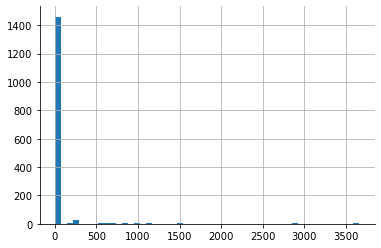

In [310]:
a_group.rev.hist(bins=50)
sns.despine()

Распределение группы В (все пользователи):

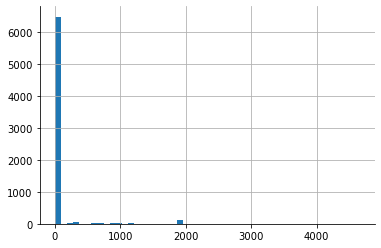

In [311]:
b_group.rev.hist(bins=50)
sns.despine()

Распределение группы А (только купившие):

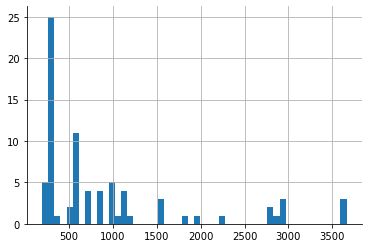

In [312]:
a_group_paid.rev.hist(bins=50)
sns.despine()

Распределение группы В (только купившие):

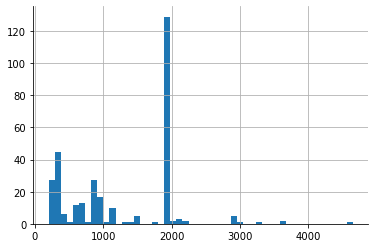

In [313]:
b_group_paid.rev.hist(bins=50)
sns.despine()

Сравним описательную статистику по всем пользователям в двух группах:

In [314]:
a_group_descr = a_group.rev.describe().to_frame().rename(columns={'rev': 'a_group'})
b_group_descr = b_group.rev.describe().to_frame().rename(columns={'rev': 'b_group'})
pd.concat([a_group_descr, b_group_descr], axis=1)

,a_group,b_group
count,1538.000000,6803.000000
mean,47.347204,58.058798
std,290.490632,313.770201
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,3660.000000,4650.000000


Сравним описательную статистику по оплатившим пользователям в двух группах:

In [315]:
a_group_descr = a_group_paid.rev.describe().to_frame().rename(columns={'rev': 'a_group'})
b_group_descr = b_group_paid.rev.describe().to_frame().rename(columns={'rev': 'b_group'})
pd.concat([a_group_descr, b_group_descr], axis=1)

,a_group,b_group
count,78.000000,314.000000
mean,933.589744,1257.878992
std,919.932711,790.864254
min,199.000000,199.000000
25%,290.000000,511.750000
50%,585.000000,1140.000000
75%,1114.750000,1900.000000
max,3660.000000,4650.000000


Посмотрим на выборосы (все пользователи):

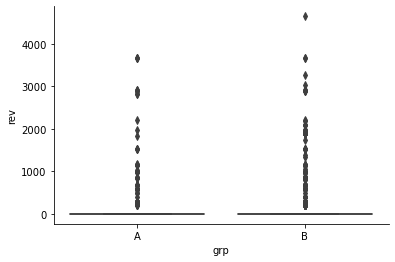

In [316]:
sns.boxplot(data=active_total, y='rev', x='grp')
sns.despine()

Посмотрим на выборосы (купившие):

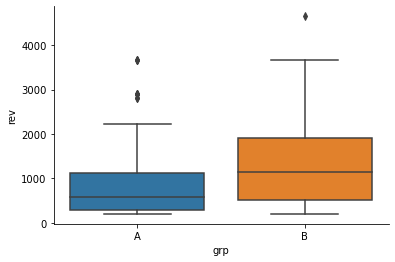

In [317]:
sns.boxplot(data=active_total_paid, y='rev', x='grp')
sns.despine()

Считаю, что следует выбрать следующие метрики:

* `CR` (конверсия онлайн платежей) - отношение количества оплативших клиентов к общему числу активных клиентов.
Может отражать юзабилити новой механики оплаты. Например часть пользователей не оплачивают т.к. сталкиваются с трудностями при оплате. Следовательно, CR выше в том варианте, где пользователю проще проивзести оплату.
* `ARPU` - отношение общей суммы на количество активных пользователей.
Важный показатель для бизнеса, при увеличении этого показателя бизнес получает больше денег.
* `ARPPU` - отношение общей суммы на количество активных оплативших пользователей.
Причины выбора этой метрики такие же, как и в случае с ARPU.


In [335]:
print('CR\nКонверсия оплативших пользователей:\nГруппа А:', 
                                             round(a_group_paid.id.count() / a_group.id.count(), 4),
                                             '\nГруппа В:', 
                                             round(b_group_paid.id.count() / b_group.id.count(), 4),
      '\nКонверсия у группы B на', round((round(b_group_paid.id.count() / b_group.id.count(), 4) - 
                                   round(a_group_paid.id.count() / a_group.id.count(), 4)) / 
                                   round(a_group_paid.id.count() / a_group.id.count(), 4), 3) * 100, '%',
      'больше, чем у группы А' if round((round(b_group_paid.id.count() / b_group.id.count(), 4) - 
                                  round(a_group_paid.id.count() / a_group.id.count(), 4)) / 
                                  round(a_group_paid.id.count() / a_group.id.count(), 4), 3) * 100 > 0 
                               else 'меньше, чем у группы А')

print('\nARPPU\nОтношение общей суммы на количество активных оплативших пользователей:\nГруппа А:',
                                                                                      round(a_group_paid.rev.mean(), 2), 
                                                                                     '\nГруппа В:', 
                                                                                      round(b_group_paid.rev.mean(), 2),
      '\nARPPU группы В на', round(round(b_group_paid.rev.mean() - a_group_paid.rev.mean(), 2) /
                             round(a_group_paid.rev.mean(), 2) * 100, 2),'%',
      'больше, чем у группы А' if round(round(b_group_paid.rev.mean() - a_group_paid.rev.mean(), 2) /
                                  round(a_group_paid.rev.mean(), 2) * 100, 2) > 0 
                               else 'меньше, чем у группы А/n')

print('\nARPU\nОтношение общей суммы на количество активных пользователей:\nГруппа А:',
                                                                          round(a_group_paid.rev.sum() / a_group.id.count(), 2),
                                                                          '\nГруппа В:', 
                                                                          round(b_group_paid.rev.sum() / b_group.id.count(), 2),
      '\nARPU группы В на', 
      round((round(b_group_paid.rev.sum() / b_group.id.count(), 2) - round(a_group_paid.rev.sum() / a_group.id.count(), 2)) /
      round(a_group_paid.rev.sum() / a_group.id.count(), 2) * 100, 2), '%',
      'больше, чем у группы А' if 
      round((round(b_group_paid.rev.sum() / b_group.id.count(), 2) - round(a_group_paid.rev.sum() / a_group.id.count(), 2)) /
      round(a_group_paid.rev.sum() / a_group.id.count(), 2) * 100, 2) > 0
                               else 'меньше, чем у группы А')

CR
Конверсия оплативших пользователей:
Группа А: 0.0507 
Группа В: 0.0462 
Конверсия у группы B на -8.9 % меньше, чем у группы А

ARPPU
Отношение общей суммы на количество активных оплативших пользователей:
Группа А: 933.59 
Группа В: 1257.88 
ARPPU группы В на 34.74 % больше, чем у группы А

ARPU
Отношение общей суммы на количество активных пользователей:
Группа А: 47.35 
Группа В: 58.06 
ARPU группы В на 22.62 % больше, чем у группы А


### Имеются ли различия в показателях и с чем они могут быть связаны?
Наблюдаем отрицательный эффект CR, и положительные эффекты в ARPU и ARPPU. Другими словами, конверсия падает, но доход на пользователя/покупателя растёт. Это может быть связано отсечением части пользователей платящих малые суммы с одновременным увеличением среднего чека.

### Являются ли эти различия статистически значимыми?
Размеры групп очень сильно отличаются, по этому классические тесты могут давать большие погрешности. В таких случаях идеально подходит бутстрап.

* Строим бутстрап распределения для групп А и Б.
* Вычислим их разницу.
* В получившемся рапределении разницы находим доверительных интервал.
* Проверяем, попадает ли доверительный интервал в 0. Если да, то нулевая гипотеза на данном уровне значимости принимается, если нет - отвергается.

Напишем функцию, которая позволит проверять гипотезы с помощью бутстрапа:

In [364]:
# функция для проверки гипотез с помощью бутстрапа
def get_bootstrap(
    data_column_1,                       # числовые значения первой (контрольной) выборки
    data_column_2,                       # числовые значения второй (тестовой) выборки
    boot_it = 1000,                      # количество бутстрэп-подвыборок
    statistic = np.mean,                 # интересующая нас статистика
    bootstrap_conf_level = 0.95,         # уровень значимости
    graph = True,                        # отрисовывать ли график
    show_progress = True                 # показывать ли индикатор прогресса
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    # выбираем отрисовывать индикатора прогресса или нет
    if show_progress:
        progress_bar = tqdm
    else:
        progress_bar = lambda x: x
    
    for i in progress_bar(range(boot_it)):        # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True                        # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_delta = samples_2 - samples_1      # находим разницу подвыборок
        boot_data.append(statistic(samples_delta)) # применяем статистику для разниц подвыборок
        
    pd_boot_data = pd.DataFrame(boot_data)

    # доверительный интервал 
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # отисовка графиков
    if graph == True:
        plt.hist(pd_boot_data[0], bins = 50)
        plt.style.use('ggplot')
        plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()
       
    return print('ci:', ci, 'p_value:', p_value, sep='\n')

Определим функции для метрик:

In [360]:
def cr_func(x):
    '''
    CR
    Для корректной работы функции в качестве аргумента y 
    необходимо передать серию со значениями 1 и 0, или True и False,
    в соответствие с тем произошло ожидаемое событие или нет.
    '''
    return sum(x) / len(x)

def arpu_func(y):
    '''
    ARPU
    Для корректной работы функции в качестве аргумента y 
    необходимо передать серию, где все NaN-значения заменнены на нули
    '''
    return np.mean(y)

def arppu_func(y):
    '''
    ARPPU
    Для корректной работы функции в качестве аргумента y 
    необходимо передать серию, где отобраны только платежи, т.е. отфильтрованы нули
    или вместо нулей стоят NaN.
    '''
    return np.mean(y)

### CR

Сформулируем нулевую и альтернативную гипотезы:

* `H0`: CR в двух группах одинаковые.
* `H1`: CR в двух группах различаются.

  0%|          | 0/1000 [00:00<?, ?it/s]

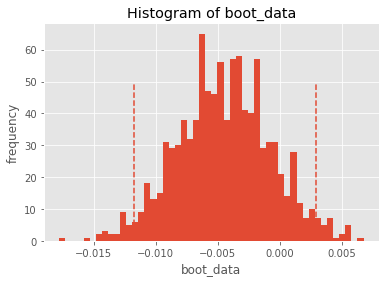

ci:
              0
0.025 -0.011763
0.975  0.002944
p_value:
0.23375810233249228


In [366]:
get_bootstrap(a_group.payment, b_group.payment, statistic = cr_func)

### ARPU
Сформулируем нулевую и альтернативную гипотезы:

* `H0`: ARPU в двух группах одинаковые.
* `H1`: ARPU в двух группах различаются.

  0%|          | 0/1000 [00:00<?, ?it/s]

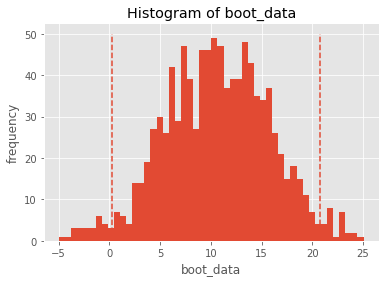

ci:
               0
0.025   0.290589
0.975  20.720605
p_value:
0.037596260831869587


In [365]:
get_bootstrap(a_group.rev, b_group.rev, statistic = arpu_func)

Доверительный интервал **не попадает в 0**, отвергаем нулевую гипотезу. ARPU в двух группах различаются.

### ARPPU
Сформулируем нулевую и альтернативную гипотезы:

* `H0`: ARPPU в двух группах одинаковые.
* `H1`: ARPPU в двух группах различаются.

  0%|          | 0/1000 [00:00<?, ?it/s]

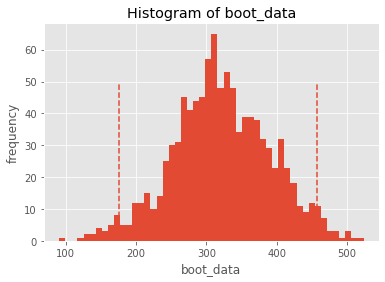

ci:
                0
0.025  175.079869
0.975  457.543725
p_value:
3.3055630396675226e-06


In [371]:
get_bootstrap(a_group.rev[a_group.rev > 0], b_group.rev[b_group.rev > 0], statistic = arppu_func)

Доверительный интервал **не попадает в 0**, отвергаем нулевую гипотезу. ARPPU в двух группах различаются.

### Стоит ли запускать новую механику на всех пользователей?
Да, новая механика оплаты даёт статистически значимый прирост в метриках ARPU и ARPPU, отрицательное изменение метрики CR не подтвердилось.

# Задание 2. SQL

## 2.1 Очень усердные ученики

Сопоставим все термины для понимания:

* карточки = задания = горошины,
* студент = ученик,
* усердный - 20 горошин (карточек / заданий) в месяц,
* очень усердный - 20 горошин (карточек / заданий) в час.

Ищем количетсво очень усердных студентов за март 2020, т.е. тех кто в течение марта 2020 смог выполнить хотябы один раз 20 горошин в течение часа.
```sql
SELECT 
    COUNT(DISTINCT sq.st_id) AS hardworking_students          -- считаем количество отобранных уникальных студентов 
FROM (                                                        -- подзапрос
    SELECT  
        st_id, 
        timest,
        SUM(correct) OVER W AS peas_per_hour                  -- считаем кличество правильно решённых горошин в окне (в час)
    FROM peas
    WHERE 
        extract(Month from timest) = 3                        -- месяц = 3 (март)
        AND 
        extract(Year from timest) = 2020                      -- год = 2020
    WINDOW W AS (
            PARTITION BY st_id                                -- группируем по id студента
            ORDER BY timest                                   -- сортируем по времени
            RANGE BETWEEN '1 hour' PRECEDING AND CURRENT ROW) -- выбираем окно с 1 часа назад до текущей строки
    ) AS sq
WHERE sq.peas_per_hour >= 20                                  -- отбираем только тех где количество горошин в час >= 20
```
